## Evaluation of results

This note book is a small boiler plate to evaluate and visualize some results

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import torch
from cnp.trainer import RegressionTrainer
from cnp.datageneration import DataGenerator
from cnp.helpers import Helper
from cnp.cnp import RegressionCNP
from cnp.run_experiment import run_experiment

import torch
import numpy as np
from copy import copy

In [106]:
# show me all results
! ls results/eval_folder

1d_gp_attention_5ctxt_2020_07_05_17_35
1d_gp_attention_5ctxt_2020_07_06_21_20
1d_gp_gated_attention_5ctxt_2020_07_07_10_17
1d_gp_max_5ctxt__2020_07_06_09_59
1d_gp_mean_5ctxt_2020_07_06_09_15
1d_gp_sum_5ctxt_2020_07_06_10_37
1d_gp_target_based_attention_5ctxt_2020_07_07_11_03
3d_polynomial_65ctxt_attention_2020_07_08_08_26
3d_polynomial_65ctxt_gatted_attention_2020_07_08_09_19
3d_polynomial_65ctxt_max_2020_07_07_18_53
3d_polynomial_65ctxt_mean_2020_07_07_17_24
3d_polynomial_65ctxt_sum_2020_07_07_20_24
3d_polynomial_65ctxt_target_based_attention_2020_07_08_10_02
greyscale_attention_40ctxt_2020_07_07_14_26
greyscale_gated_attention_40ctxt_2020_07_07_17_16
greyscale_max_40ctxt_2020_07_06_17_20
greyscale_mean_40ctxt_2020_07_06_16_49
greyscale_sum_40ctxt_2020_07_07_12_01
greyscale_target_based_attention_40ctxt_2020_07_07_21_47


In [3]:
def calc_experiment_mse_stats(experiment_name):
    with open(os.path.join('results',experiment_name,'task_mses.txt')) as file:
        mses = file.readlines()
        mses = [float(mse) for mse in mses]
        mean_mse = np.mean(mses)
        var_mse = np.std(mses)
    return mean_mse, var_mse

def get_mse_stats(temp_folder):
    !find . -name ".DS_Store" -delete
    eval_path = os.path.join(os.getcwd(),"results",'eval_folder')
    mses = {}
    for folder in os.listdir(eval_path):
        mean_mse, var_mse = calc_experiment_mse_stats(folder)
        mses[folder] = {"mean_mse": mean_mse, "var_mse" :var_mse}
    return mses


In [115]:
mse_stats = get_mse_stats('eval_folder')

In [116]:
[(key,mse_stats[key]) for key in mse_stats.keys() if 'grey' in key]

[('greyscale_mean_40ctxt_2020_07_06_16_49',
  {'mean_mse': 0.044608393106609585, 'var_mse': 0.016109707898182463}),
 ('greyscale_target_based_attention_40ctxt_2020_07_07_21_47',
  {'mean_mse': 0.044234503330662846, 'var_mse': 0.012957551615864822}),
 ('greyscale_sum_40ctxt_2020_07_07_12_01',
  {'mean_mse': 0.06828799735754729, 'var_mse': 0.01884807750827801}),
 ('greyscale_attention_40ctxt_2020_07_07_14_26',
  {'mean_mse': 0.06828492753207684, 'var_mse': 0.01976234646120979}),
 ('greyscale_gated_attention_40ctxt_2020_07_07_17_16',
  {'mean_mse': 0.04809390670619905, 'var_mse': 0.016445350238964658}),
 ('greyscale_max_40ctxt_2020_07_06_17_20',
  {'mean_mse': 0.04213869809173047, 'var_mse': 0.014783199822464125})]

In [101]:
def plot_progress(sub_folder, experiment, title, interval=1000):
    path = os.path.join('results',sub_folder)
    with open(os.path.join(path, experiment, 'train_loss.txt')) as f:
        train_loss = [float(val.strip()) for val in f.readlines()][::interval][1:]
    with open(os.path.join(path, experiment, 'vali_loss.txt')) as f:
        vali_loss = [float(val.strip()) for val in f.readlines()][1:]
    x_values = np.arange(0,len(train_loss))
    plt.figure(figsize=(10,5))
    plt.plot(x_values, train_loss, label='training loss', color='#012d64')
    plt.plot(x_values, vali_loss, label='validation loss', color='#960e1e')
    plt.title(f'Training progress: {title}')
    plt.ylabel("Negative log likelihood")
    plt.xlabel("Training epsiodes (in '000)")
    plt.legend() 
    plt.show()
    plt.close()

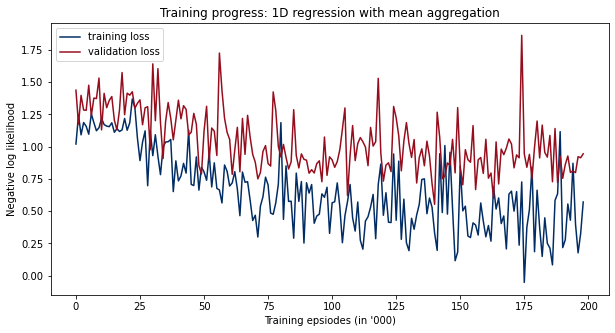

In [108]:
plot_progress('eval_folder','1d_gp_mean_5ctxt_2020_07_06_09_15', title="1D regression with mean aggregation")

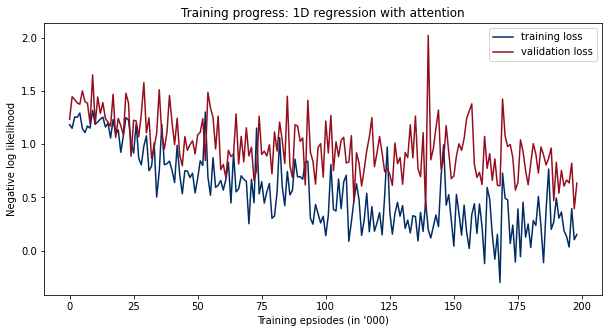

In [112]:
plot_progress('eval_folder','1d_gp_attention_5ctxt_2020_07_06_21_20',
              title="1D regression with attention",interval=1000)

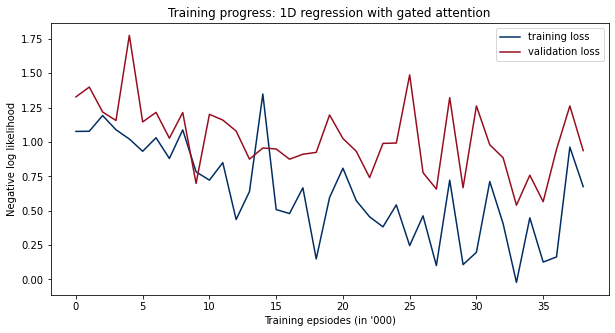

In [113]:
plot_progress('eval_folder','1d_gp_target_based_attention_5ctxt_2020_07_07_11_03', title="1D regression with gated attention",
             interval=5000
    )

In [93]:

def calc_early_stopping_threshold(loss):
    
    for index, val in enumerate(loss):
        if index>3:
            if loss[index-3] < loss[index-2] < loss[index-1] < loss[index]:
                return index, val
                
def get_all_stopping_values(eval_path):
    !find . -name ".DS_Store" -delete
    convergence_dict = {}
    for folder in os.listdir(eval_path):
        with open(os.path.join(eval_path, folder, 'vali_loss.txt')) as f:
            try:
                vali_loss = [float(val.strip()) for val in f.readlines()][1:]
                index, val = calc_early_stopping_threshold(vali_loss)
            except TypeError:
                index = "No convergence"
                val = np.nan
        convergence_dict[folder] = {'index': index, 'val':val}
    return convergence_dict

In [94]:
convergence_dict = get_all_stopping_values('results/eval_folder')

In [145]:
[(key, convergence_dict[key]) for key in convergence_dict.keys() if '1d' in key]

[('1d_gp_target_based_attention_5ctxt_2020_07_07_11_03',
  {'index': 19, 'val': 1.1957354545593262}),
 ('1d_gp_attention_5ctxt_2020_07_06_21_20',
  {'index': 35, 'val': 1.5106228590011597}),
 ('1d_gp_sum_5ctxt_2020_07_06_10_37', {'index': 85, 'val': 1.188907504081726}),
 ('1d_gp_attention_5ctxt_2020_07_05_17_35',
  {'index': 83, 'val': 1.0722546577453613}),
 ('1d_gp_gated_attention_5ctxt_2020_07_07_10_17',
  {'index': 25, 'val': 1.060346007347107}),
 ('1d_gp_max_5ctxt__2020_07_06_09_59',
  {'index': 34, 'val': 1.4390736818313599}),
 ('1d_gp_mean_5ctxt_2020_07_06_09_15',
  {'index': 74, 'val': 1.0078877210617065})]

## Making some predictions 1D regression

In [154]:
def run_test(experiment_name, result_path = 'results/eval_folder', num_context=None):
    files = os.listdir(os.path.join(os.getcwd(),result_path, experiment_name))
    with open(os.path.join(result_path, experiment_name,'config_file.json')) as file:
        experiment_config = json.load(file)
    
    experiment_config['experiment_params']['train_on_gpu'] = False
    if num_context:
        experiment_config['cnp_params']['max_contx'] = num_context
    
    
    CondNeuralProcess = RegressionCNP(**experiment_config['cnp_params'])

    trainer = RegressionTrainer(
        data_kwargs=experiment_config['data_kwargs'],
        cnp=CondNeuralProcess,
         **experiment_config['experiment_params'])

    encoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'encoder'),map_location=torch.device('cpu'))
    decoder_state_dict = torch.load(os.path.join(result_path, experiment_name, 'decoder'),map_location=torch.device('cpu'))
    if "aggregator" in files:
        aggregator_state_dict = torch.load(
            os.path.join(result_path, experiment_name, 'aggregator'),map_location=torch.device('cpu'))
    else:
        aggregator_state_dict = None


    total_mse, task_mses = trainer.run_test(
        encoder_state_dict,
        decoder_state_dict,
        aggregator_state_dict=aggregator_state_dict,
        batch_size_test=experiment_config['train_kwargs']['batch_size_test'],
        plot_mode=experiment_config['train_kwargs']['plot_mode'])


In [148]:
experiment_names = os.listdir(os.path.join(os.getcwd(),'results/eval_folder'))

In [149]:
[name for name in experiment_names if '1d' in name]

['1d_gp_target_based_attention_5ctxt_2020_07_07_11_03',
 '1d_gp_attention_5ctxt_2020_07_06_21_20',
 '1d_gp_sum_5ctxt_2020_07_06_10_37',
 '1d_gp_gated_attention_5ctxt_2020_07_07_10_17',
 '1d_gp_max_5ctxt__2020_07_06_09_59',
 '1d_gp_mean_5ctxt_2020_07_06_09_15']

NOW PLOTTING 1d_gp_target_based_attention_5ctxt_2020_07_07_11_03


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


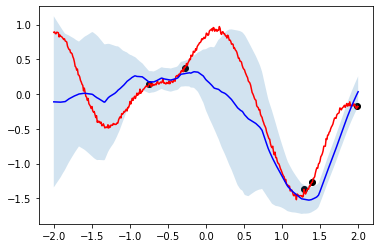

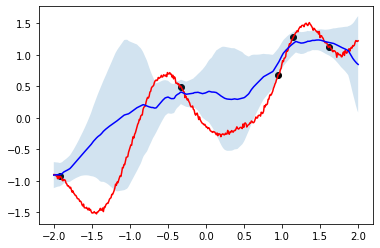

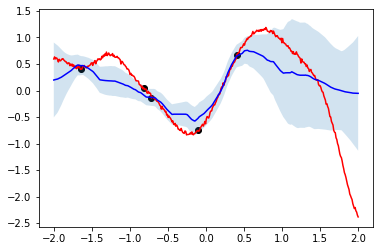

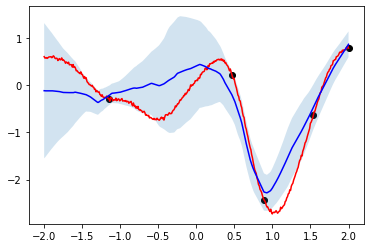

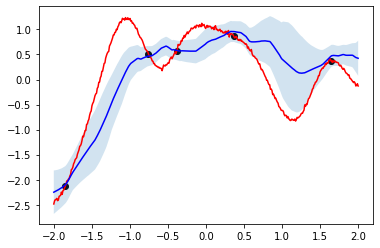

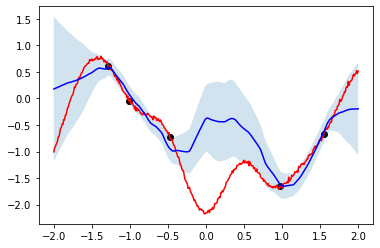

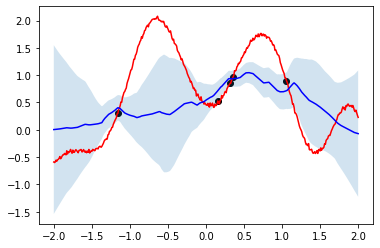

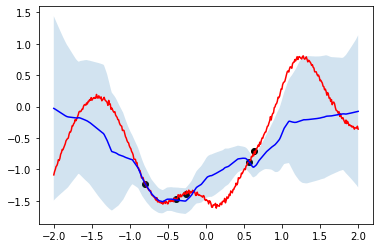

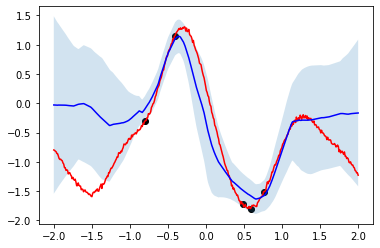

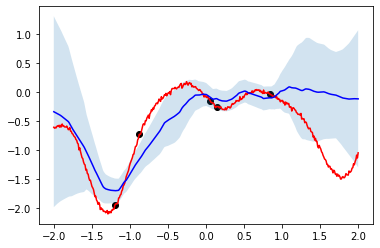

NOW PLOTTING 1d_gp_attention_5ctxt_2020_07_06_21_20


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
BasicMLPAggregator(
  (_process_input): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
seed is set


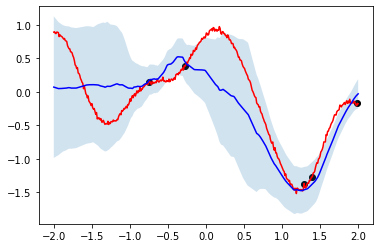

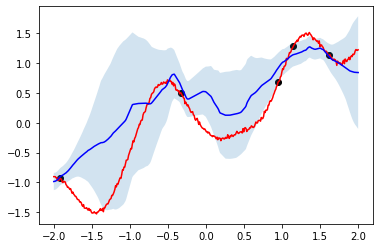

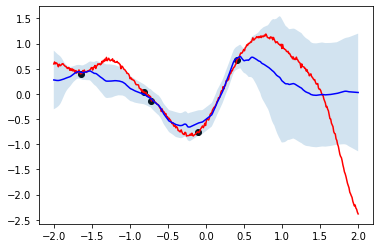

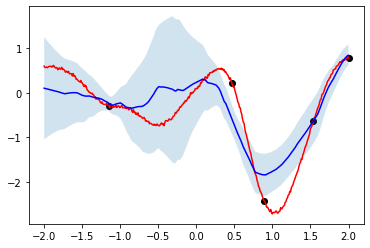

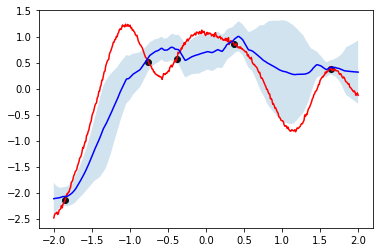

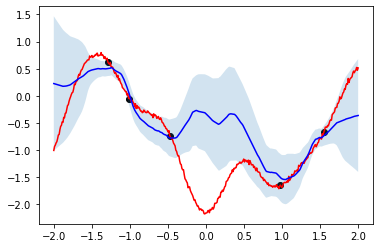

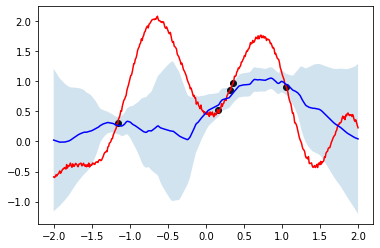

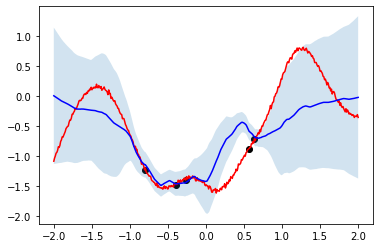

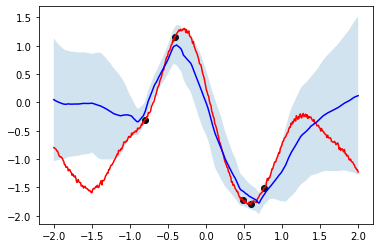

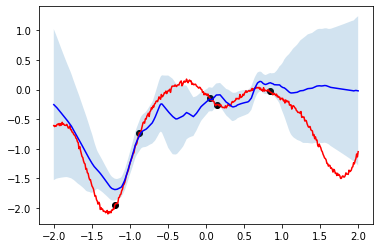

NOW PLOTTING 1d_gp_sum_5ctxt_2020_07_06_10_37


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


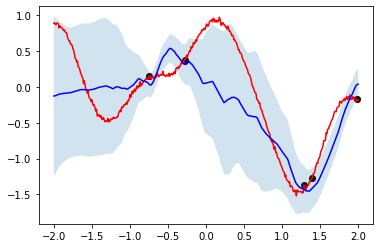

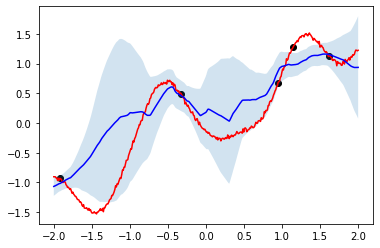

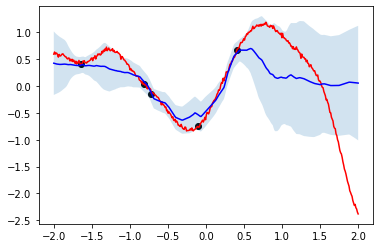

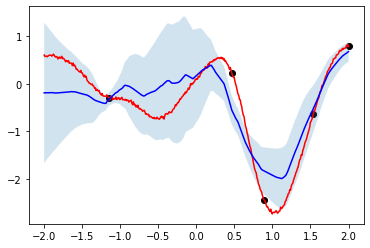

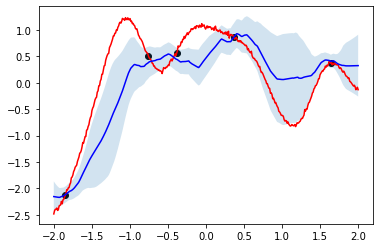

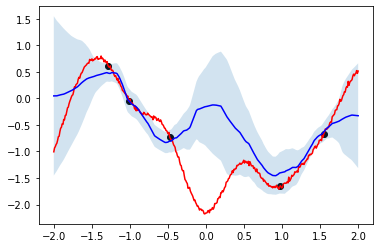

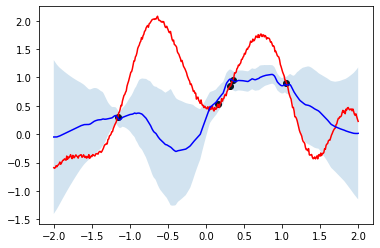

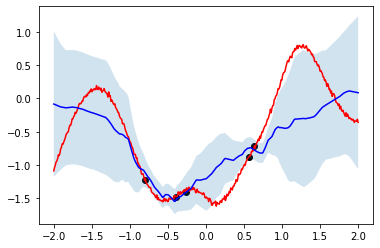

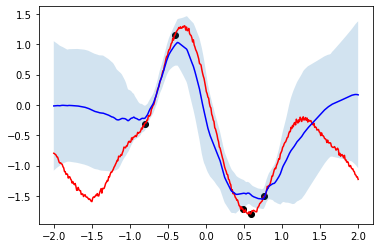

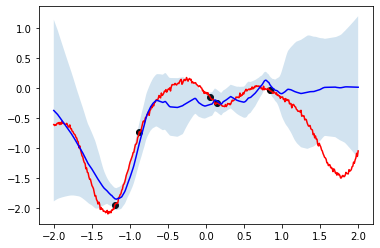

NOW PLOTTING 1d_gp_gated_attention_5ctxt_2020_07_07_10_17


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
GatedMLPAggregator(
  (attention_W): Linear(in_features=128, out_features=128, bias=True)
  (attenion_V): Linear(in_features=128, out_features=128, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)
seed is set


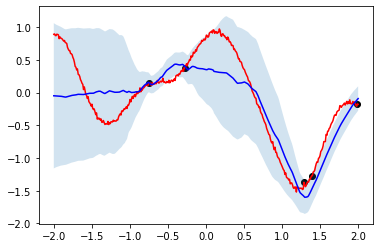

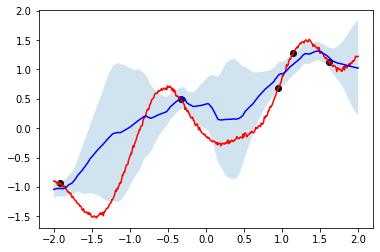

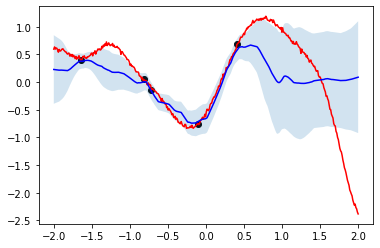

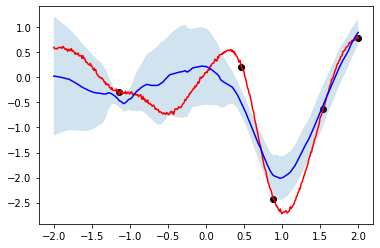

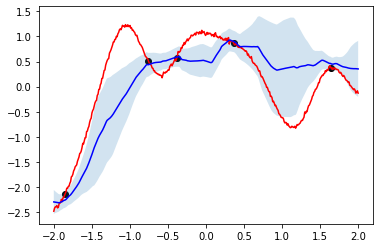

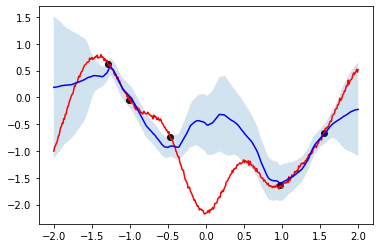

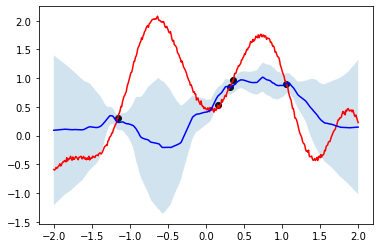

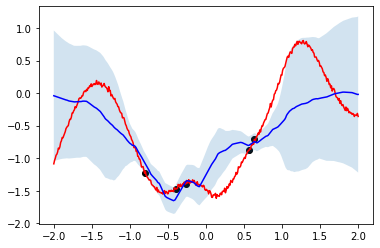

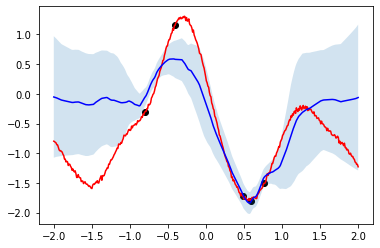

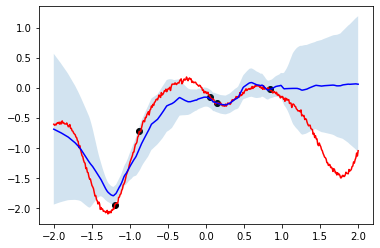

NOW PLOTTING 1d_gp_max_5ctxt__2020_07_06_09_59


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


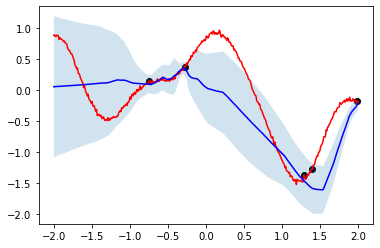

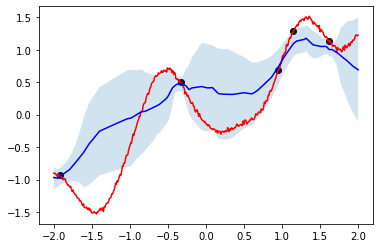

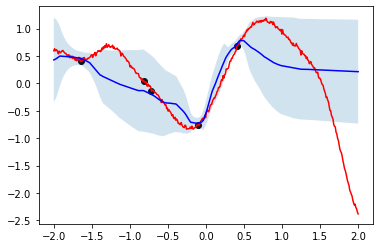

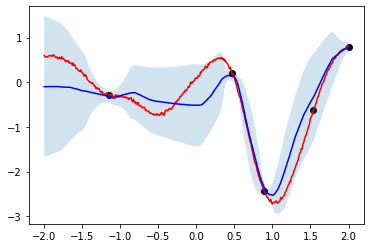

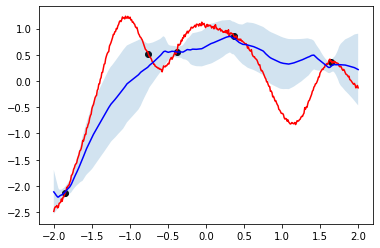

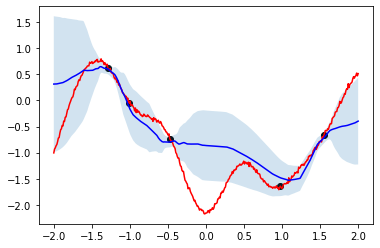

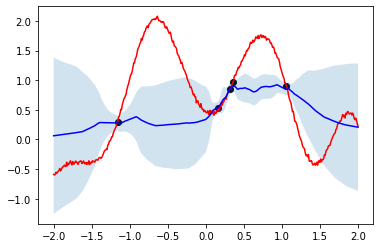

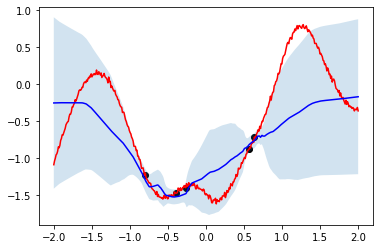

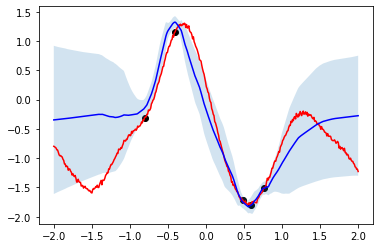

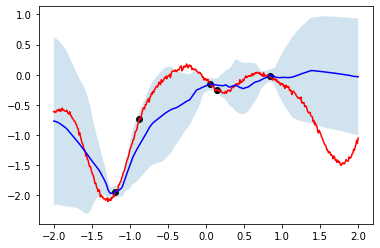

NOW PLOTTING 1d_gp_mean_5ctxt_2020_07_06_09_15


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


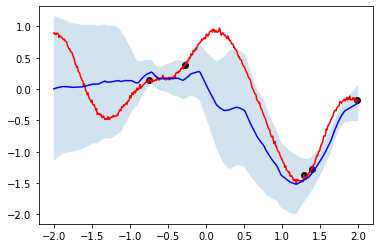

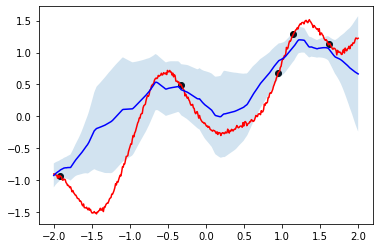

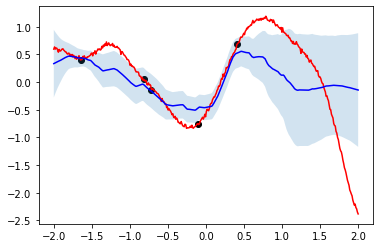

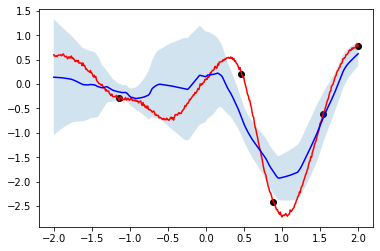

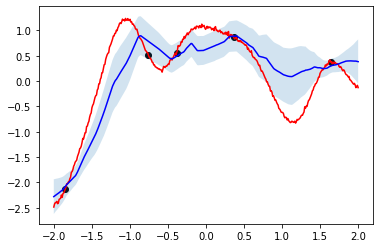

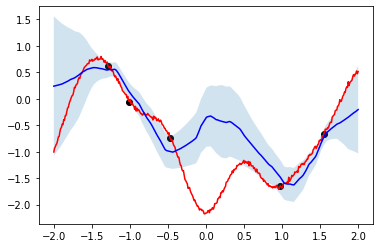

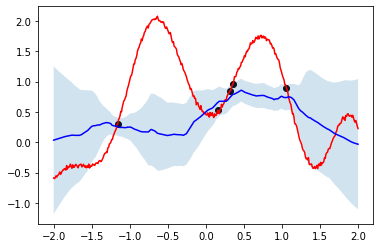

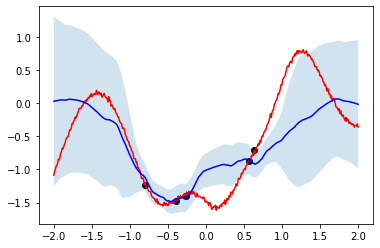

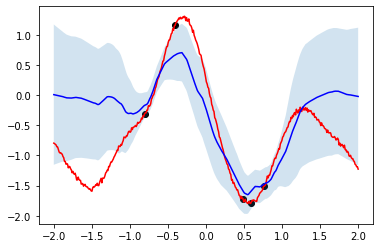

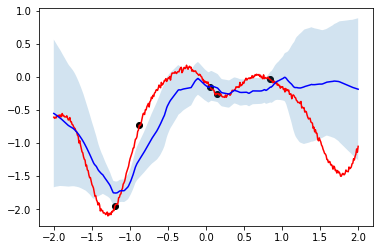

In [150]:
for name in [name for name in experiment_names if '1d' in name]:
    print(f'NOW PLOTTING {name}\n\n')
    run_test(name)

NOW PLOTTING greyscale_mean_40ctxt_2020_07_06_16_49


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


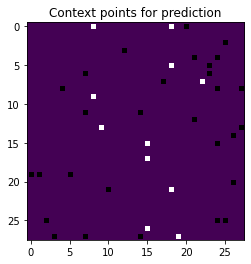

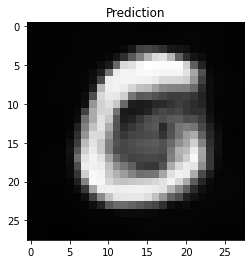

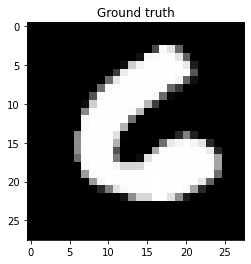

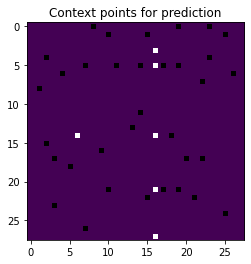

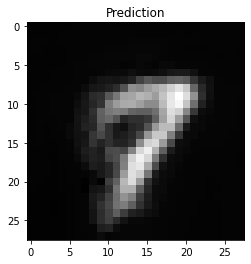

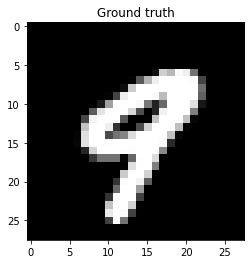

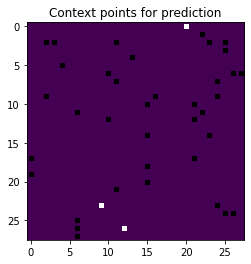

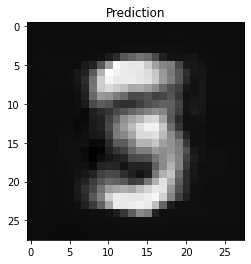

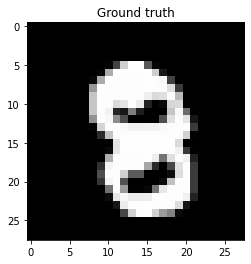

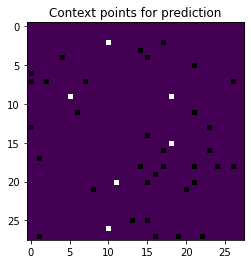

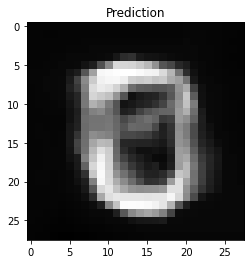

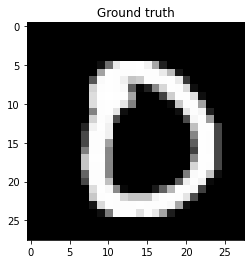

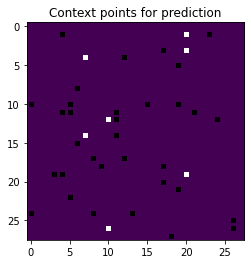

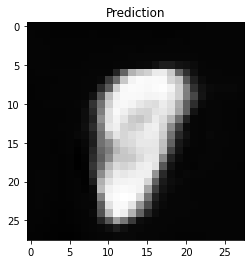

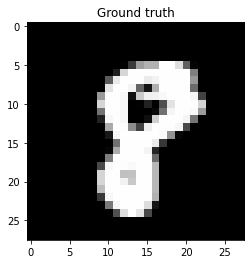

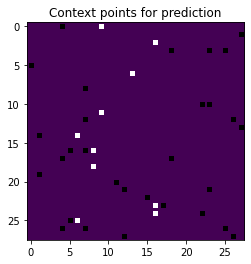

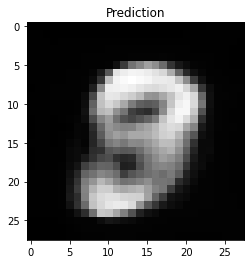

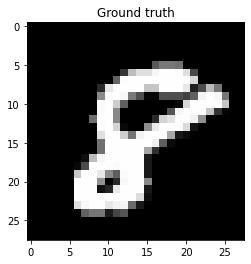

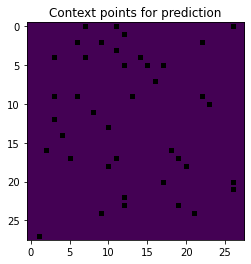

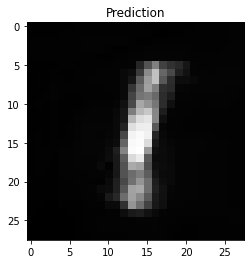

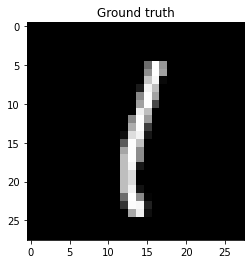

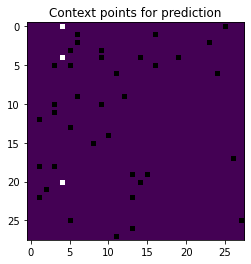

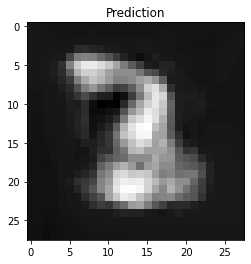

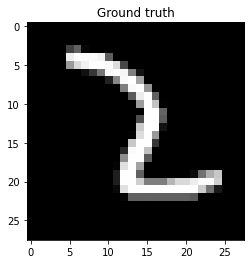

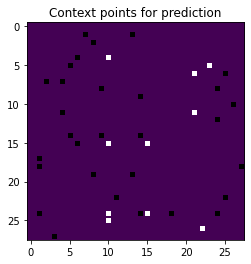

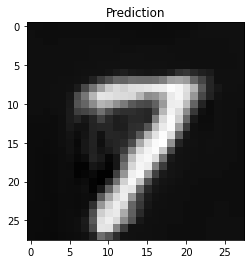

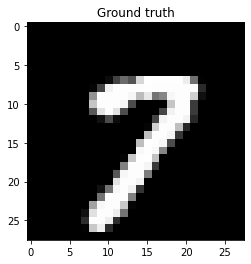

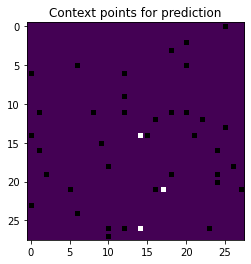

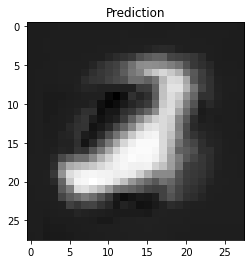

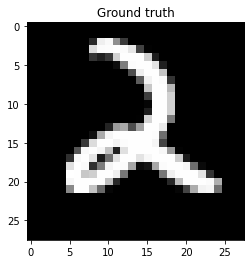

NOW PLOTTING greyscale_target_based_attention_40ctxt_2020_07_07_21_47


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


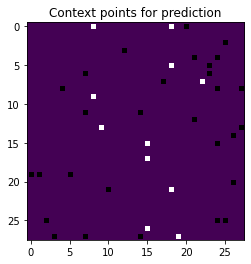

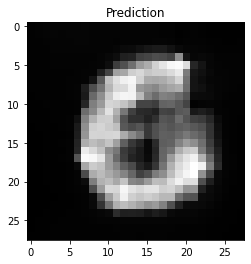

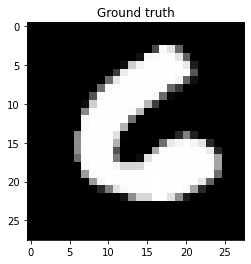

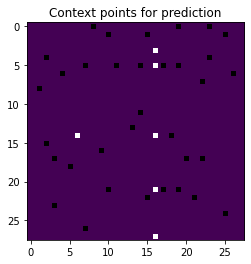

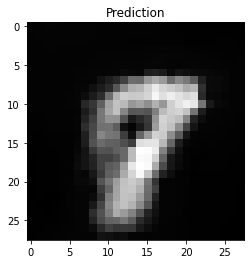

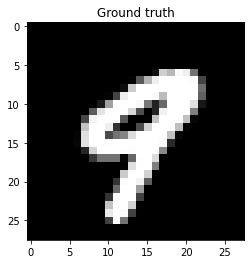

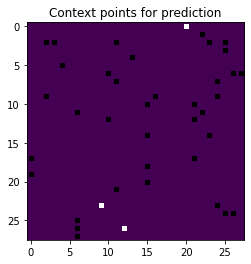

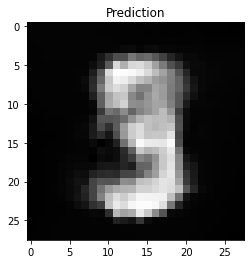

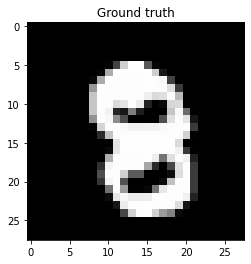

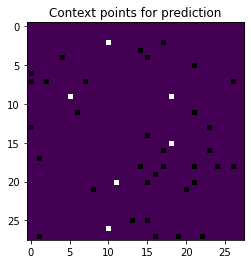

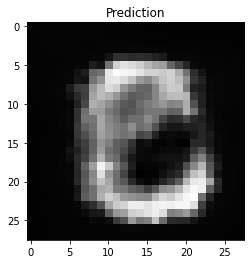

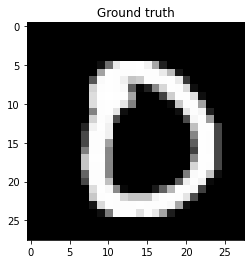

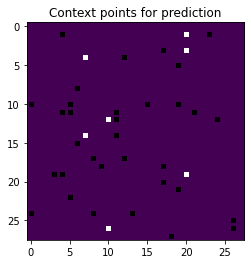

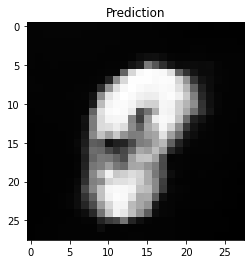

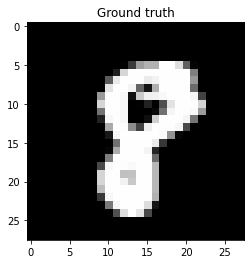

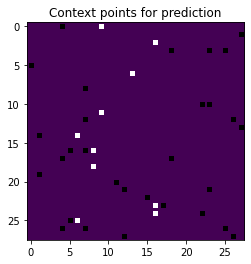

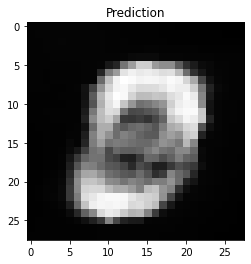

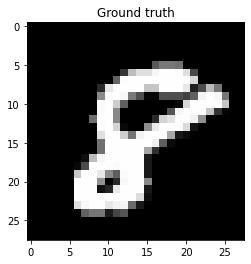

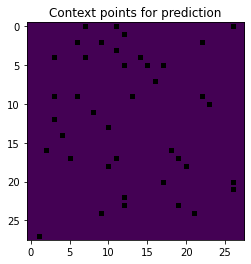

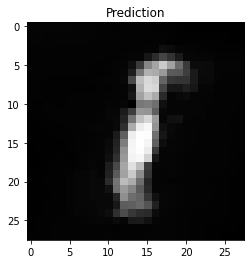

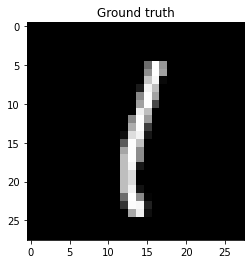

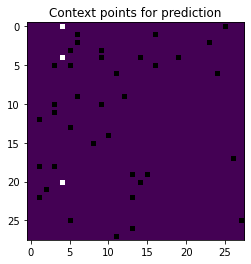

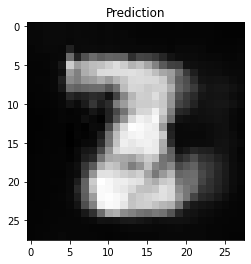

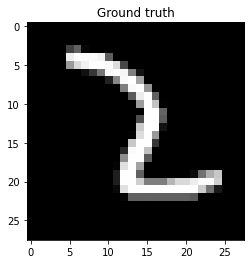

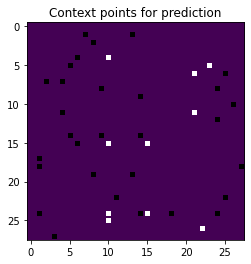

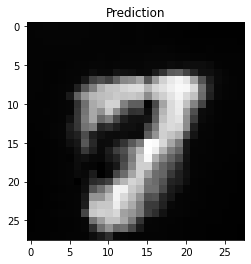

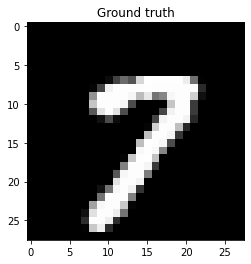

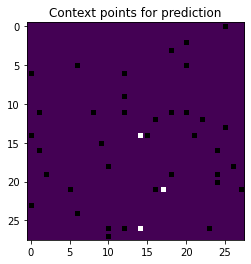

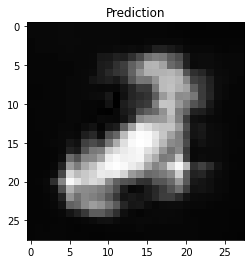

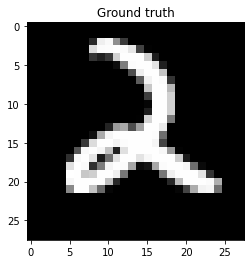

NOW PLOTTING greyscale_sum_40ctxt_2020_07_07_12_01


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


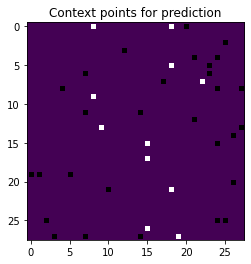

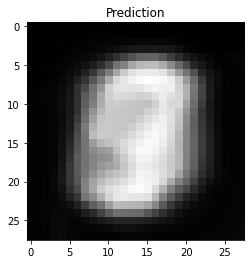

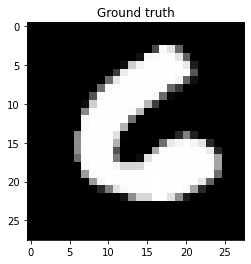

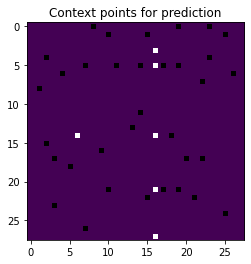

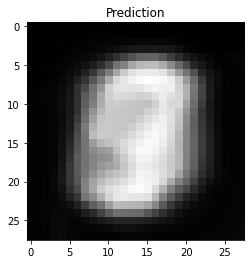

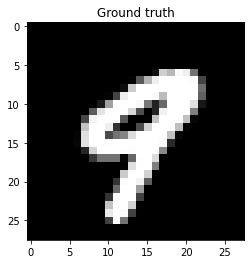

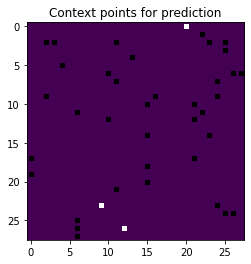

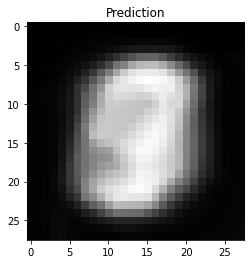

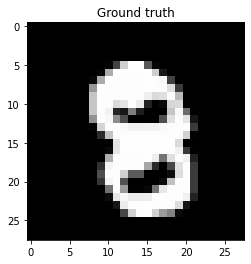

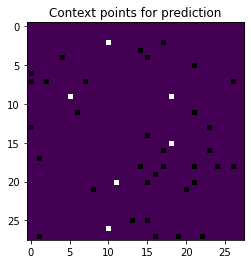

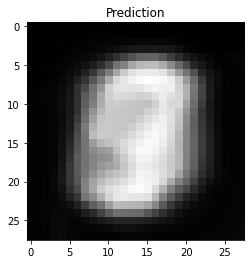

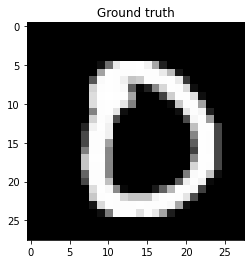

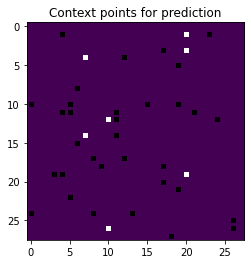

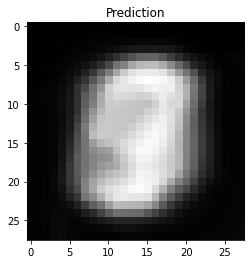

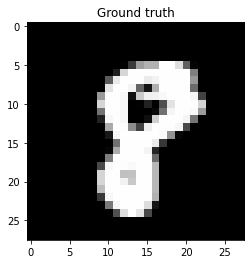

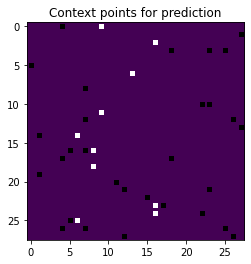

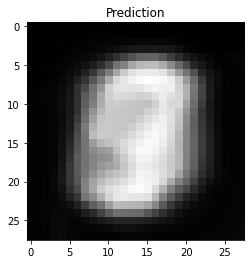

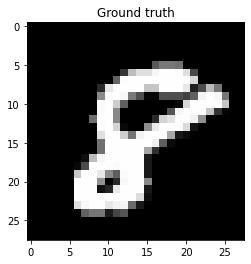

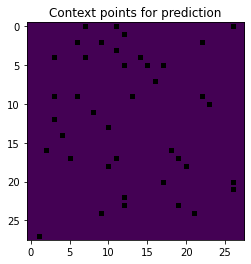

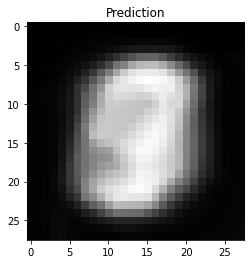

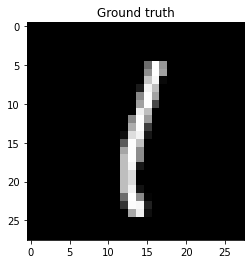

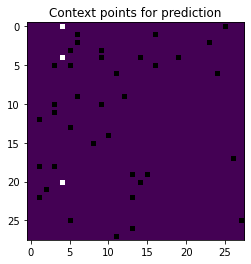

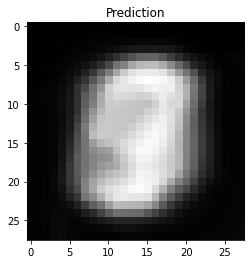

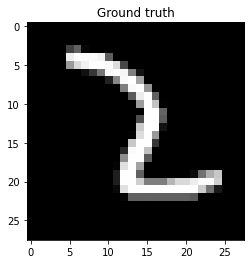

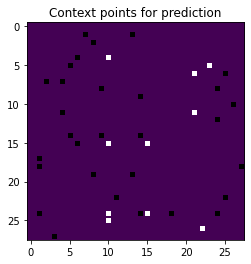

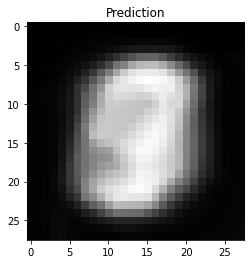

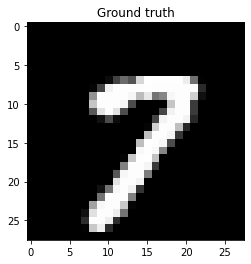

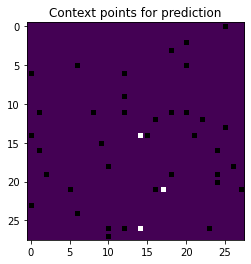

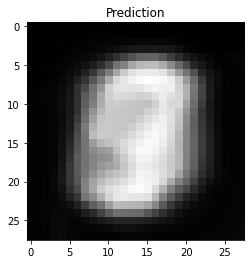

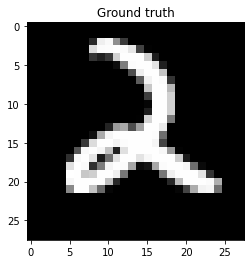

NOW PLOTTING greyscale_attention_40ctxt_2020_07_07_14_26


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
BasicMLPAggregator(
  (_process_input): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
seed is set


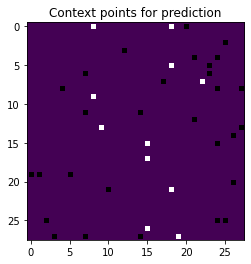

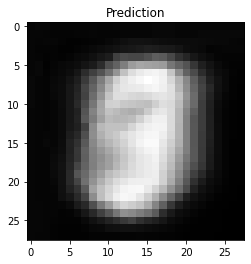

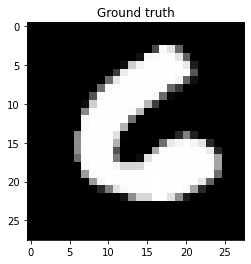

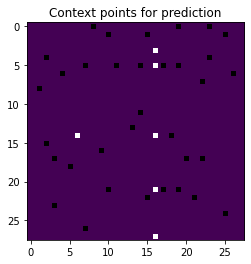

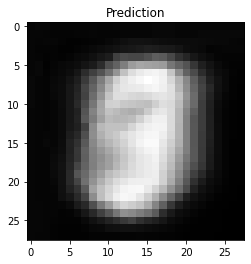

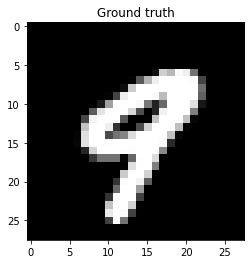

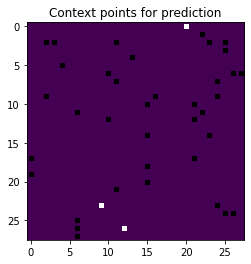

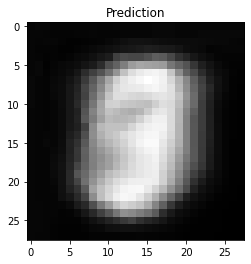

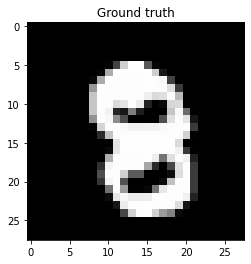

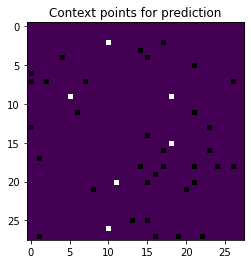

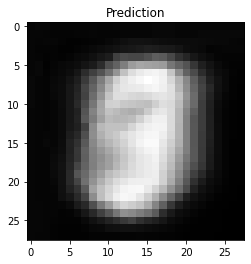

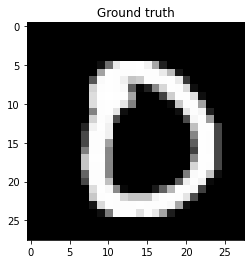

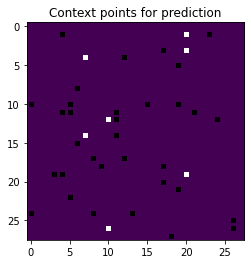

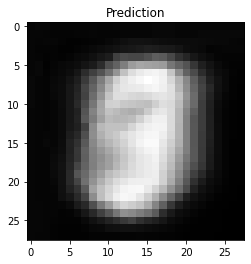

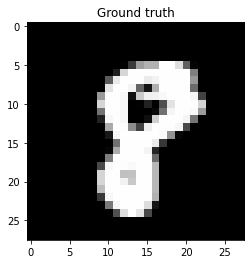

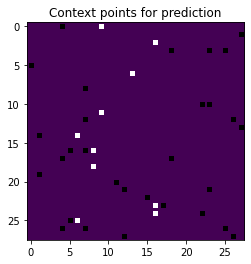

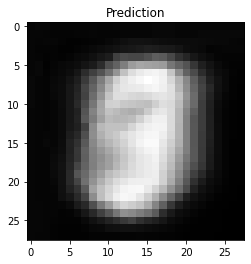

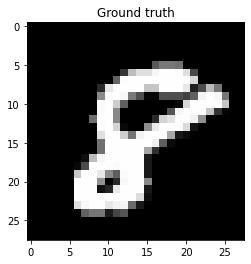

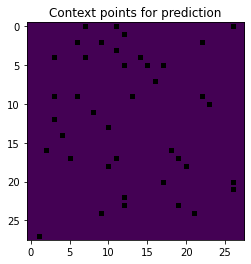

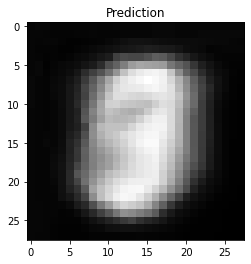

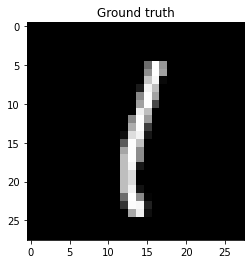

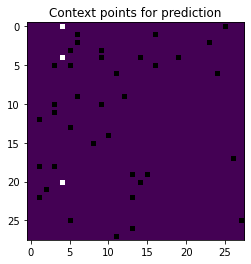

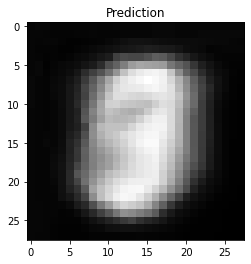

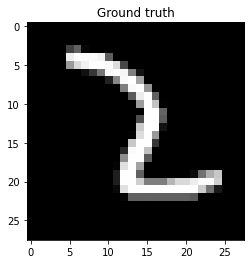

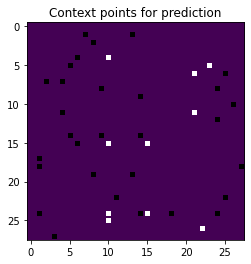

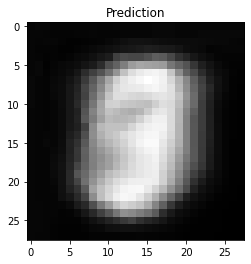

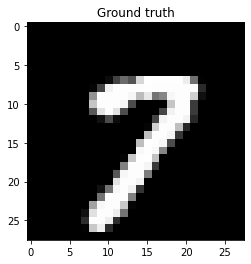

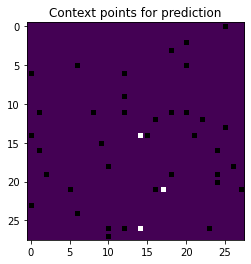

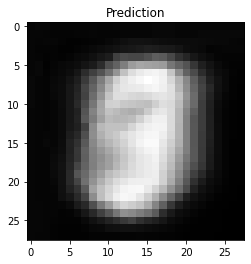

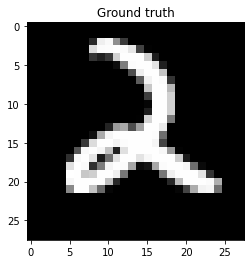

NOW PLOTTING greyscale_gated_attention_40ctxt_2020_07_07_17_16


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
GatedMLPAggregator(
  (attention_W): Linear(in_features=128, out_features=128, bias=True)
  (attenion_V): Linear(in_features=128, out_features=128, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (softmax): Softmax(dim=1)
)
seed is set


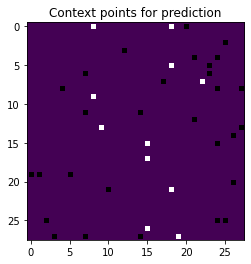

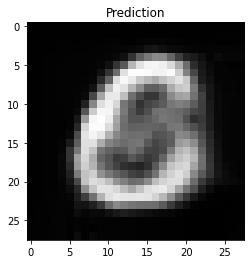

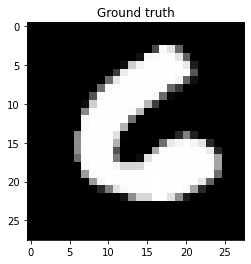

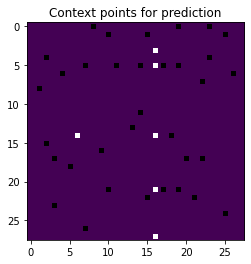

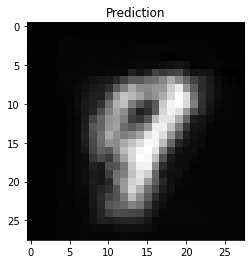

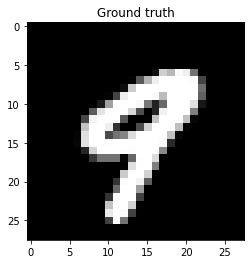

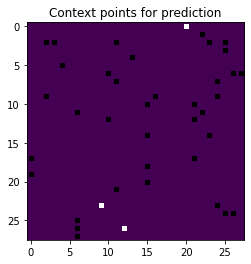

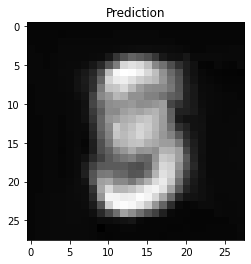

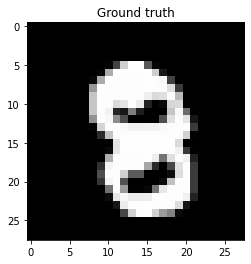

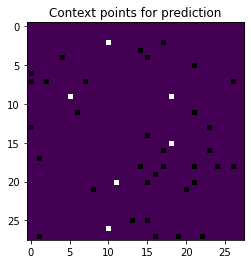

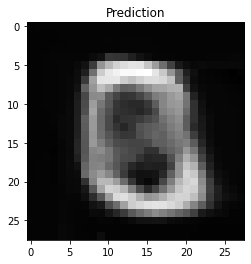

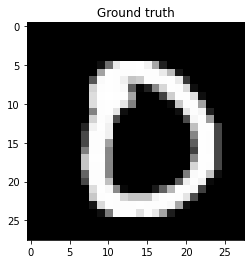

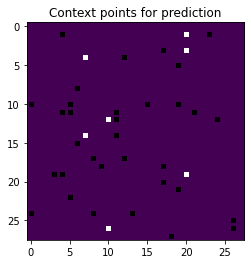

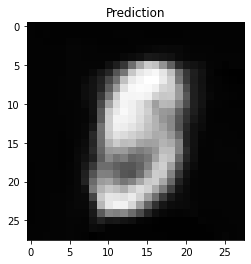

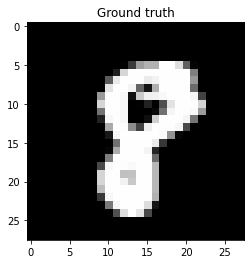

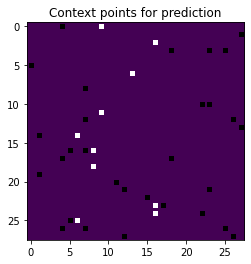

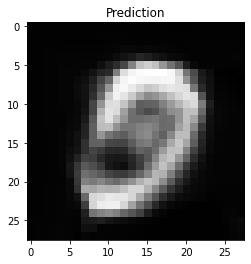

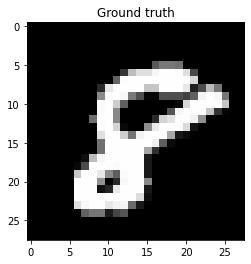

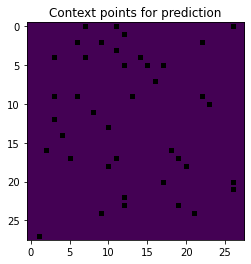

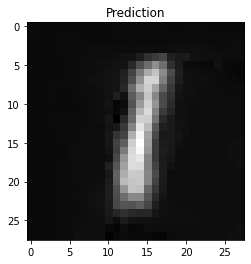

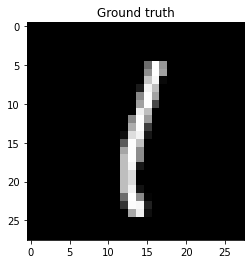

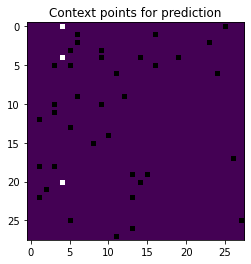

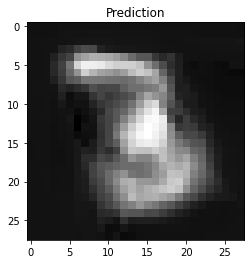

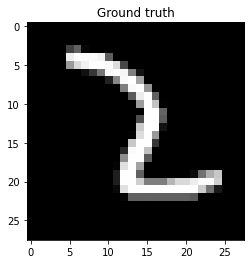

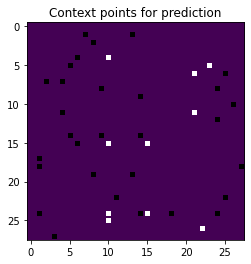

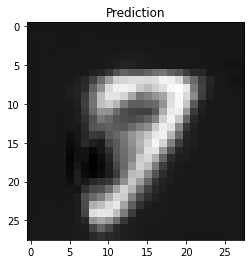

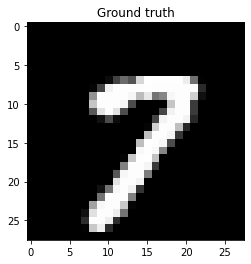

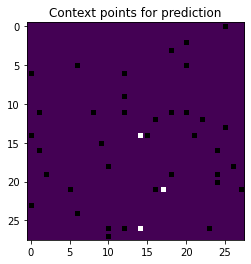

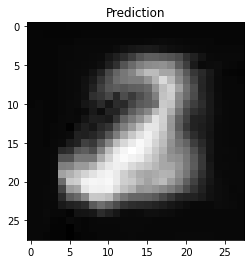

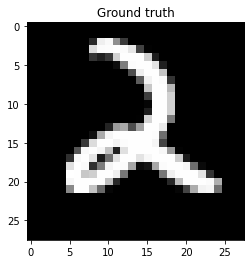

NOW PLOTTING greyscale_max_40ctxt_2020_07_06_17_20


Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=130, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


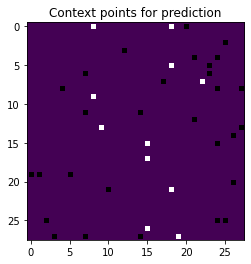

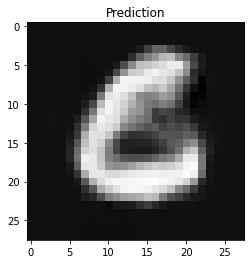

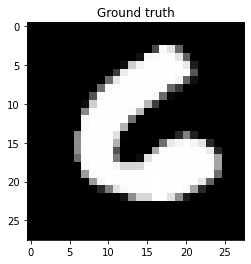

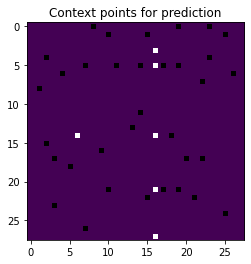

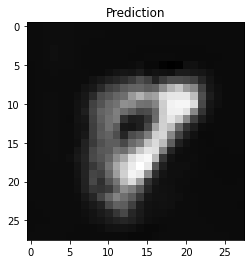

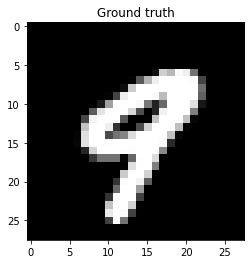

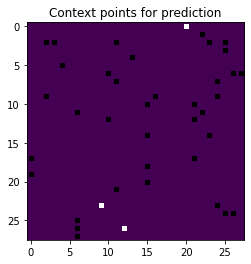

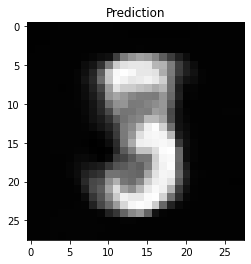

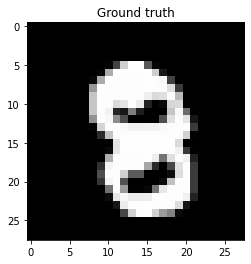

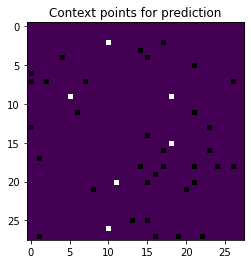

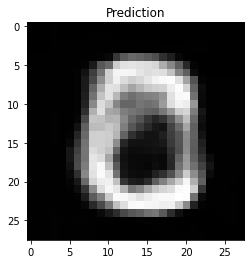

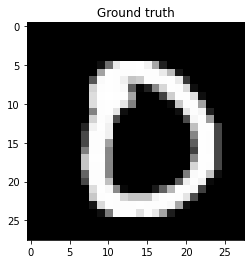

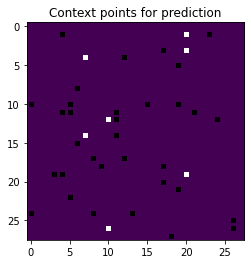

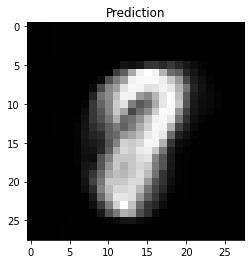

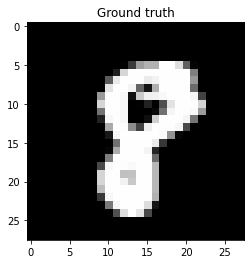

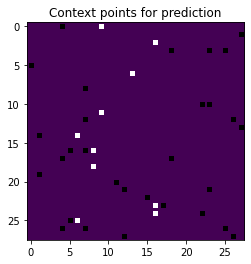

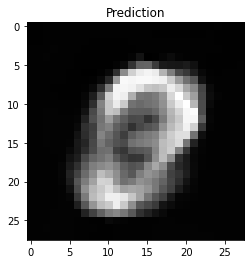

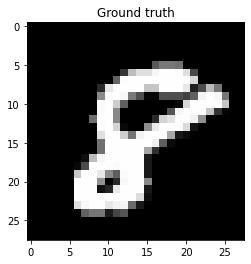

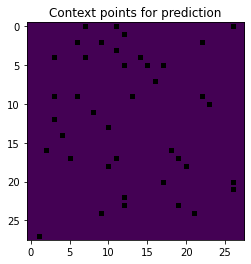

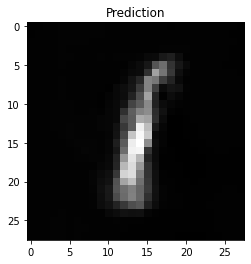

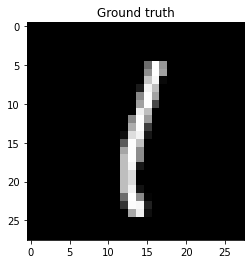

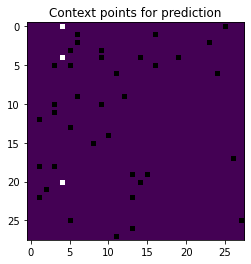

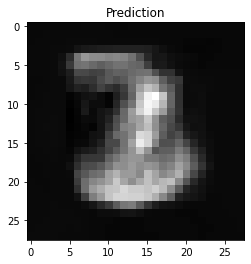

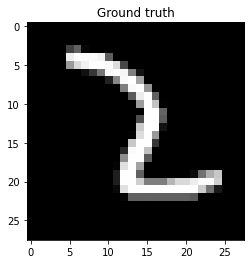

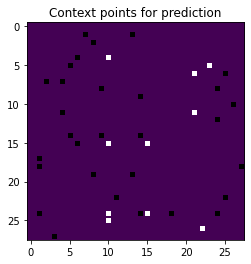

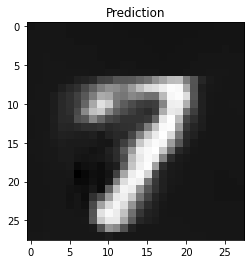

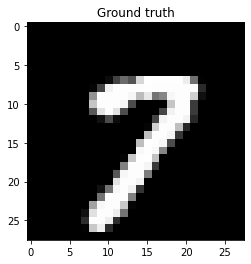

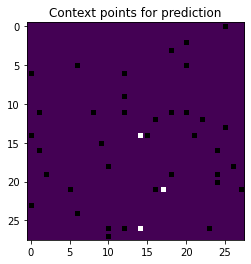

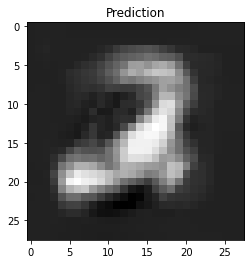

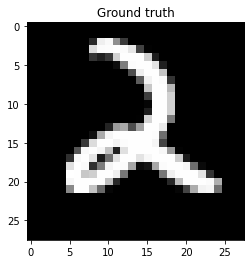

In [152]:
for name in [name for name in experiment_names if 'grey' in name]:
    print(f'NOW PLOTTING {name}\n\n')
    run_test(name)

Decoder(
  (_process_input): Sequential(
    (0): Linear(in_features=129, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)
Encoder(
  (_process_input): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
  )
)
seed is set


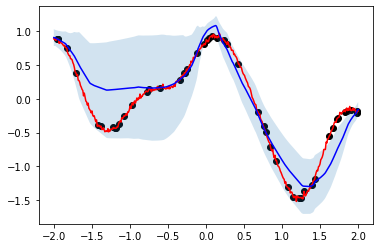

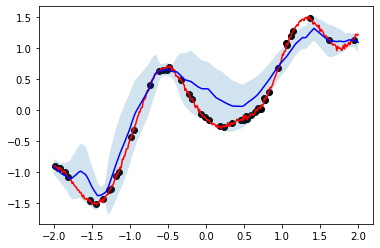

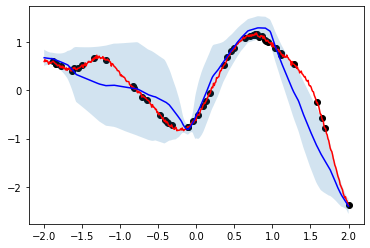

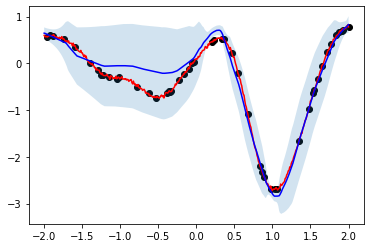

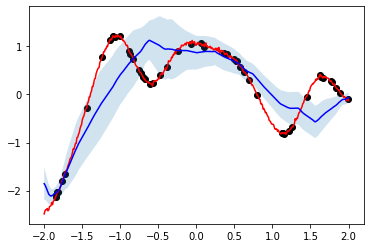

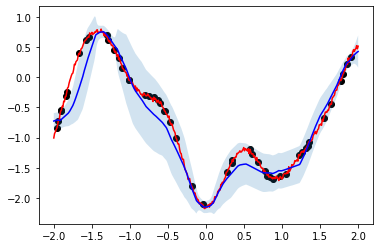

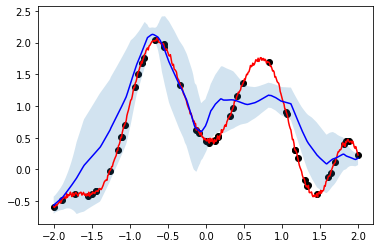

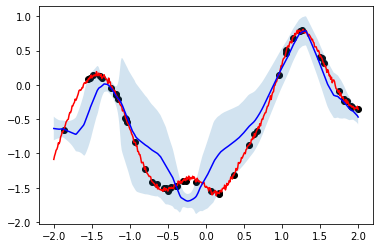

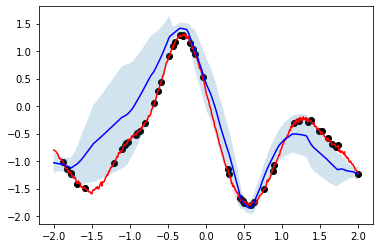

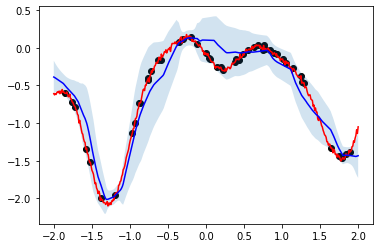

In [157]:
## Increasing the number of context points
run_test('1d_gp_max_5ctxt__2020_07_06_09_59',num_context=100)